<a href="https://colab.research.google.com/github/jianfeiZhao/Supply-Chain-Analysis/blob/master/pred_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
import xgboost as xgb

In [2]:
import pickle
with open('/content/drive/My Drive/Colab Notebooks/data/data.pkl', 'rb') as file:
  data = pickle.load(file)
data.head(3)

,Unnamed: 0,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,Order Customer Id,Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode,Customer Fullname,order_year,order_month,order_weekday,order_hour,order_month_year
0,0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Cally,20755,Holloway,XXXXXXXXX,Consumer,PR,5365 Noble Nectar Island,725.0,2,Fitness,18.251453,-66.037056,Pacific Asia,Bekasi,Indonesia,20755,77202,1360,13.110000,0.04,180517,327.75,0.29,1,327.75,314.640015,91.250000,Southeast Asia,Java Occidental,COMPLETE,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class,CallyHolloway,2018,1,2,22,2018-01
1,1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,Puerto Rico,XXXXXXXXX,Irene,19492,Luna,XXXXXXXXX,Consumer,PR,2679 Rustic Loop,725.0,2,Fitness,18.279451,-66.037064,Pacific Asia,Bikaner,India,19492,75939,1360,16.389999,0.05,179254,327.75,-0.80,1,327.75,311.359985,-249.089996,South Asia,RajastÃ¡n,PENDING,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class,IreneLuna,2018,1,5,12,2018-01
2,2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,EE. UU.,XXXXXXXXX,Gillian,19491,Maldonado,XXXXXXXXX,Consumer,CA,8510 Round Bear Gate,95125.0,2,Fitness,37.292233,-121.881279,Pacific Asia,Bikaner,India,19491,75938,1360,18.030001,0.06,179253,327.75,-0.80,1,327.75,309.720001,-247.779999,South Asia,RajastÃ¡n,CLOSED,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class,GillianMaldonado,2018,1,5,12,2018-01


对欺诈订单进行预测（分类任务）

对延迟发货进行预测

In [3]:
# 欺诈label设置
data['fraud'] = np.where(data['Order Status'] == 'SUSPECTED_FRAUD', 1, 0) # 相等为1，不等为0
# 延期label设置
data['late_delivery'] = np.where(data['Delivery Status'] == 'Late delivery', 1, 0)

In [4]:
# 特征选择
data.drop(['Customer Email', 'Customer Fname', 'Customer Id', 'Customer Lname', 'Customer Password',
    'Order Zipcode', 'Product Card Id', 'Product Category Id', 'Product Description', 'Product Status',
    'Product Image', 'Customer Zipcode', 'Order Status', 'Delivery Status', 'Longitude', 'Latitude',
    'Customer Street', 'Order Item Id', 'Late_delivery_risk'], axis=1, inplace=True)
#data.info()

# 再次去除多余的项
data.drop(['Order Profit Per Order', 'Order Item Total', 'Product Price', 'Sales', 'Order Item Cardprod Id',
    'Order Id', 'Unnamed: 0'], axis=1, inplace=True)

# 查看object特征
cat_cols = data.select_dtypes(include='object').columns
num_cols = data.select_dtypes(exclude='object').columns
data['Customer Fullname'] = data['Customer Fullname'].astype('str')
# LabelEncoder 
le = LabelEncoder()
for col in cat_cols:
  #print(col)
  data[col] = le.fit_transform(data[col])
data.head(3)

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Category Id,Category Name,Customer City,Customer Country,Customer Segment,Customer State,Department Id,Department Name,Market,Order City,Order Country,Order Customer Id,Order Item Discount,Order Item Discount Rate,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Order Region,Order State,Product Name,shipping date (DateOrders),Shipping Mode,Customer Fullname,order_year,order_month,order_weekday,order_hour,order_month_year,fraud,late_delivery
0,1,3,4,91.250000,314.640015,73,40,66,1,0,36,2,4,3,331,70,20755,13.110000,0.04,327.75,0.29,1,15,475,78,27149,3,1875,2018,1,2,22,36,0,0
1,3,5,4,-249.089996,311.359985,73,40,66,1,0,36,2,4,3,391,69,19492,16.389999,0.05,327.75,-0.80,1,13,841,78,2209,3,5374,2018,1,5,12,36,0,1
2,0,4,4,-247.779999,309.720001,73,40,452,0,0,5,2,4,3,391,69,19491,18.030001,0.06,327.75,-0.80,1,13,841,78,1980,3,4426,2018,1,5,12,36,0,0


In [5]:
# 星期几数值大小无意义，做one-hot encoder
#data['order_weekday'].value_counts()
#data['order_weekday'] = 
#data['order_year'].value_counts()

(180519, 35)

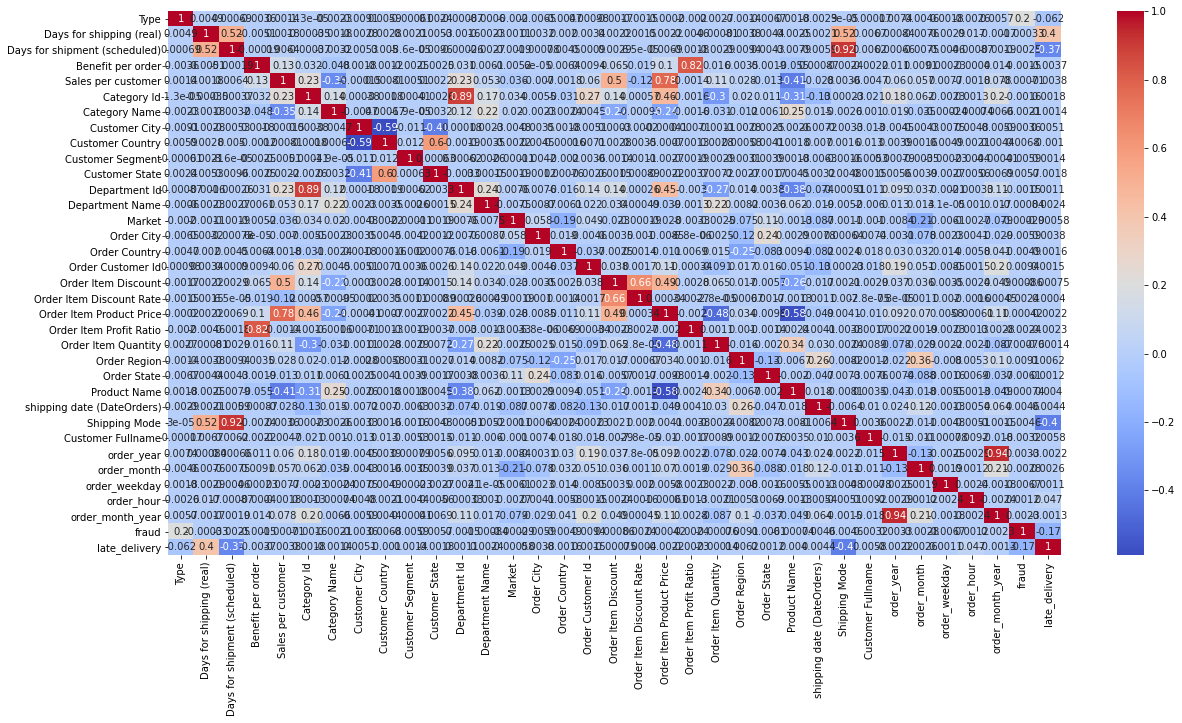

In [5]:
# 热力图展示特征相关性
plt.figure(figsize=(20,10))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
data.shape

In [6]:
# 数据集构造切分
X_data = data.loc[:, data.columns != 'fraud']
y_data = data['fraud']
X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test = train_test_split(X_data, y_data, test_size=0.2)

X_late = data.loc[:, data.columns != 'late_delivery']
y_late = data['late_delivery']
X_late_train, X_late_test, y_late_train, y_late_test = train_test_split(X_late, y_late, test_size=0.2)

# 数据规范化
sc = StandardScaler()
X_fraud_train = sc.fit_transform(X_fraud_train)
X_fraud_test = sc.transform(X_fraud_test)
X_late_train = sc.transform(X_late_train)
X_late_test = sc.transform(X_late_test)

In [7]:
# 模型评估
def model_stats(model, X_train, X_test, y_train, y_test, name='Fraud'):
  model = model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  accuracy = accuracy_score(y_pred, y_test)
  recall = recall_score(y_pred, y_test)
  confusion = confusion_matrix(y_pred, y_test)
  f1 = f1_score(y_pred, y_test)
  print('\nModel used:', model)
  print('{} Accuracy: {}%'.format(name, accuracy*100))
  print('{} Recall: {}%'.format(name, recall*100))
  print('{} Confusion Matrix:\n {}'.format(name, confusion))
  print('{} F1: {}%'.format(name, f1*100))

In [17]:
# logistic regression
model_fraud = LogisticRegression()
model_late = LogisticRegression()

model_stats(model_fraud, X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test, 'Fraud')
model_stats(model_late, X_late_train, X_late_test, y_late_train, y_late_test, 'Late Delivery')


Model used: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Fraud Accuracy: 97.83126523376912%
Fraud Recall: 54.317548746518106%
Fraud Confusion Matrix:
 [[35126   619]
 [  164   195]]
Fraud F1: 33.24808184143223%

Model used: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Late Delivery Accuracy: 98.74806115665854%
Late Delivery Recall: 97.7811594914339%
Late Delivery Confusion Matrix:
 [[15733     0]
 [  452 19919]]
Late Delivery F1: 98.

LR，GaussianNB，LinearSVC，KNeighborsClassifier，LinearDiscriminantAnalysis，DecisionTreeClassifier，RandomForestClassifier，XGBClassifier


In [20]:
model_fraud = GaussianNB()
model_late = GaussianNB()

model_stats(model_fraud, X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test, 'Fraud')
model_stats(model_late, X_late_train, X_late_test, y_late_train, y_late_test, 'Late Delivery')


Model used: GaussianNB(priors=None, var_smoothing=1e-09)
Fraud Accuracy: 88.1287391978728%
Fraud Recall: 15.96078431372549%
Fraud Confusion Matrix:
 [[31004     0]
 [ 4286   814]]
Fraud F1: 27.527899898545822%

Model used: GaussianNB(priors=None, var_smoothing=1e-09)
Late Delivery Accuracy: 57.29836029248837%
Late Delivery Recall: 56.37063451632988%
Late Delivery Confusion Matrix:
 [[  769     1]
 [15416 19918]]
Late Delivery F1: 72.09744267279603%


In [22]:
model_fraud = LinearSVC()
model_late = LinearSVC()

model_stats(model_fraud, X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test, 'Fraud')
model_stats(model_late, X_late_train, X_late_test, y_late_train, y_late_test, 'Late Delivery')

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



Model used: LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Fraud Accuracy: 97.74263239530246%
Fraud Recall: 49.852507374631266%
Fraud Confusion Matrix:
 [[35120   645]
 [  170   169]]
Fraud F1: 29.314830875975716%

Model used: LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Late Delivery Accuracy: 98.74806115665854%
Late Delivery Recall: 97.7811594914339%
Late Delivery Confusion Matrix:
 [[15733     0]
 [  452 19919]]
Late Delivery F1: 98.87813353189377%


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [23]:
model_fraud = KNeighborsClassifier()
model_late = KNeighborsClassifier()

model_stats(model_fraud, X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test, 'Fraud')
model_stats(model_late, X_late_train, X_late_test, y_late_train, y_late_test, 'Late Delivery')


Model used: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
Fraud Accuracy: 97.89220031021493%
Fraud Recall: 73.87387387387388%
Fraud Confusion Matrix:
 [[35261   732]
 [   29    82]]
Fraud F1: 17.729729729729733%

Model used: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
Late Delivery Accuracy: 84.84378462220252%
Late Delivery Recall: 85.8539732962724%
Late Delivery Confusion Matrix:
 [[13335  2622]
 [ 2850 17297]]
Late Delivery F1: 86.34253481755104%


In [16]:
model_fraud = DecisionTreeClassifier()
model_late = DecisionTreeClassifier()

model_stats(model_fraud, X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test, 'Fraud')
model_stats(model_late, X_late_train, X_late_test, y_late_train, y_late_test, 'Late Delivery')


Model used: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Fraud Accuracy: 99.02780855306891%
Fraud Recall: 76.51162790697674%
Fraud Confusion Matrix:
 [[35095   149]
 [  202   658]]
Fraud F1: 78.94421115776844%

Model used: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       ran

[21 12  8 11  5 19  6 18 28 24 17  2 20  4  3 22  9 13 29 15 10 32 30 31
 23 14  7 27  0 26 25 33 16  1]


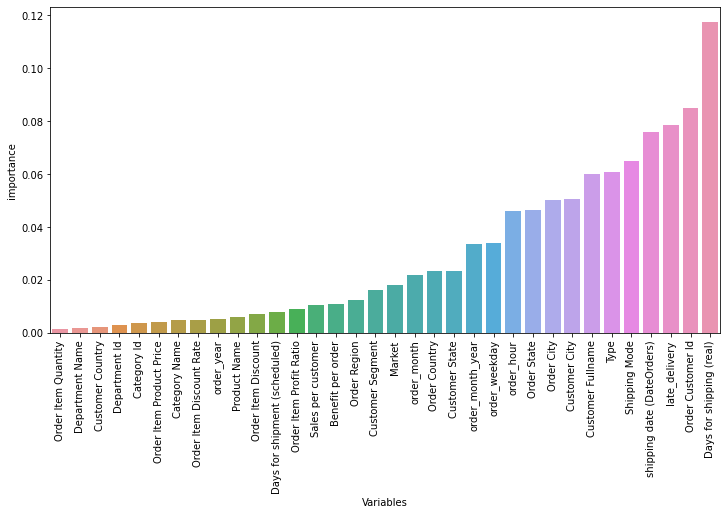

In [14]:
# 根据决策树模型得到fraud的feature_importance
cols = model_fraud.feature_importances_.argsort()
print(cols)
plt.figure(figsize=(12,6))
feat_importance = pd.DataFrame({'Variables': X_data.columns[cols], 'importance': model_fraud.feature_importances_[cols]})
sns.barplot(x='Variables', y='importance', data=feat_importance)
plt.xticks(rotation=90)
plt.show()

[21  6 28 19 11 12  5 24  8 18 17 13  9  3  4 29 20 22 30 32 15 31  7  0
 10 23 14 27 16 25 26 33  2  1]


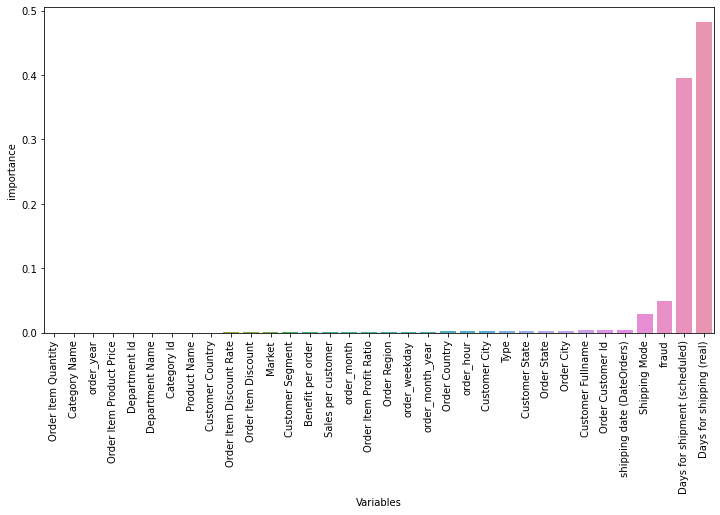

In [17]:
# 根据决策树模型得到late delivery的feature_importance
cols = model_late.feature_importances_.argsort()
print(cols)
plt.figure(figsize=(12,6))
feat_importance = pd.DataFrame({'Variables': X_late.columns[cols], 'importance': model_late.feature_importances_[cols]})
sns.barplot(x='Variables', y='importance', data=feat_importance)
plt.xticks(rotation=90)
plt.show()

In [18]:
model_fraud = RandomForestClassifier()
model_late = RandomForestClassifier()

model_stats(model_fraud, X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test, 'Fraud')
model_stats(model_late, X_late_train, X_late_test, y_late_train, y_late_test, 'Late Delivery')


Model used: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Fraud Accuracy: 98.82561489031686%
Fraud Recall: 98.48101265822785%
Fraud Confusion Matrix:
 [[35291   418]
 [    6   389]]
Fraud F1: 64.72545757071548%

Model used: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurit

In [19]:
model_fraud = xgb.XGBClassifier()
model_late = xgb.XGBClassifier()

model_stats(model_fraud, X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test, 'Fraud')
model_stats(model_late, X_late_train, X_late_test, y_late_train, y_late_test, 'Late Delivery')


Model used: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Fraud Accuracy: 97.91712829603368%
Fraud Recall: 63.95939086294417%
Fraud Confusion Matrix:
 [[35226   681]
 [   71   126]]
Fraud F1: 25.099601593625497%

Model used: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
     

In [20]:
data.to_csv('SupplyChain_clean.csv')